In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../..")
sys.path.append("../../..")

# 1. Open dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path = "/data/pcpe_01.csv"
df = pd.read_csv(path, delimiter=';')
df

,NUMERO_CASO,NUMERO_BANCO,NUMERO_AGENCIA,NUMERO_CONTA,TIPO,CPF_CNPJ_TITULAR,CNAB,CNAB=101,CNAB=119,CNAB=120,...,NUMERO_AGENCIA_OD,NUMERO_CONTA_OD,I-a,I-b,I-c,I-d,I-e,DIA_LANCAMENTO,MES_LANCAMENTO,ANO_LANCAMENTO
0,CASO-01-L1K4U4,O6Y,1965,153602,2,ZS9104223348,218,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2017
1,CASO-01-L1K4U4,O6Y,1965,153602,2,ZS9104223348,218,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2017
2,CASO-01-L1K4U4,L6X,742,810886,2,RJ3341718546,211,0,0,0,...,75,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2017
3,CASO-01-L1K4U4,L6X,742,810886,2,RJ3341718546,211,0,0,0,...,75,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2017
4,CASO-01-L1K4U4,W5Y,554,902093,1,IK6356601049,201,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138300,CASO-01-L1K4U4,O9A,490,296083,1,KO2307484082,206,0,0,0,...,490,296083.0,NaN,NaN,NaN,NaN,NaN,1,3,2021
138301,CASO-01-L1K4U4,O9A,490,296083,1,KO2307484082,102,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2021
138302,CASO-01-L1K4U4,O9A,490,296083,2,KO2307484082,102,0,0,0,...,490,296083.0,NaN,NaN,NaN,NaN,NaN,1,3,2021
138303,CASO-01-L1K4U4,O6Y,5776,191834,1,KO2307484082,205,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2021


In [5]:
from publications.lacci2024.analysis import LacciAnalysis


# 2. Descriptive Statistics

In [6]:
lacci_analysis = LacciAnalysis(df) 
df_descriptive = lacci_analysis.get_results_descriptive()
print(df_descriptive.to_latex())


\begin{tabular}{lrr}
\toprule
Typology & I-d & None \\
\midrule
Accounts & 11 & 177 \\
Individuals/Companies & 6 & 35 \\
Transactions & 10446 & 127859 \\
\bottomrule
\end{tabular}



# 3. Data Spliting

In [7]:
from mlex import PastFutureSplit
split = PastFutureSplit()
X, y = lacci_analysis.get_X_y()
X_train, X_test, y_train, y_test = split.train_test_split(X, y)

2024-06-03 19:02:35.740071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 4. Model Training

In [8]:
from mlex import (
    SimplePipeline,
    SimpleRNNModel,
    SimpleLSTMModel,
    SimpleGruModel,
)

In [9]:
from mlex import (
    SequenceTransfomer
)

In [10]:
import tensorflow as tf
sequence_length = 50
sequence = SequenceTransfomer(sequence_length=sequence_length)
data_test = sequence.transform(X_test, y_test)

data_train_full = sequence.transform(X_train, y_train)

N = len(data_train_full)
train_size = int(0.7 * N)
val_size = int(0.3 * N)

data_train = data_train_full.take(train_size)
data_val = data_train_full.skip(train_size)


2024-06-03 19:02:37.019042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 19:02:37.019310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 19:02:37.022793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
model_rnn = SimpleRNNModel(X_train.shape)
model_lstm = SimpleLSTMModel(X_train.shape)
model_gru = SimpleGruModel(X_train.shape)
import keras
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

pipelines = []
models = [model_rnn, model_lstm, model_gru]
# models = [model]

for m in models:
    pipeline = SimplePipeline(final_model=m.get_model())
    history = m.fit(data_train, epochs=30, validation_data=data_val, callbacks = [callback])
    pipelines.append(m)

Epoch 1/30


2024-06-03 19:02:38.425320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [69103]
	 [[{{node Placeholder/_8}}]]
2024-06-03 19:02:38.425714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [69152,45]
	 [[{{node Placeholder/_0}}]]
2024-06-03 19:02:39.820481: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb64002c8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-03 19:02:39.820518: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA G

1512/1512 [==============================] - ETA: 0s - loss: 0.3076 - acc: 0.9093 - auc: 0.6236

2024-06-03 19:04:02.947741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2024-06-03 19:04:02.948468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [69152,45]
	 [[{{node Placeholder/_0}}]]


1512/1512 [==============================] - 93s 60ms/step - loss: 0.3076 - acc: 0.9093 - auc: 0.6236 - val_loss: 0.4800 - val_acc: 0.8341 - val_auc: 0.4970
Epoch 2/30
1512/1512 [==============================] - 91s 60ms/step - loss: 0.2877 - acc: 0.9136 - auc: 0.7070 - val_loss: 0.4777 - val_acc: 0.8341 - val_auc: 0.5231
Epoch 3/30
1512/1512 [==============================] - 90s 60ms/step - loss: 0.2763 - acc: 0.9139 - auc: 0.7269 - val_loss: 0.4764 - val_acc: 0.8341 - val_auc: 0.5257
Epoch 4/30
1512/1512 [==============================] - 91s 60ms/step - loss: 0.2712 - acc: 0.9139 - auc: 0.7382 - val_loss: 0.4749 - val_acc: 0.8341 - val_auc: 0.5286
Epoch 5/30
1512/1512 [==============================] - 91s 60ms/step - loss: 0.2732 - acc: 0.9139 - auc: 0.7424 - val_loss: 0.5146 - val_acc: 0.8341 - val_auc: 0.4547
Epoch 6/30
1512/1512 [==============================] - 91s 60ms/step - loss: 0.2737 - acc: 0.9138 - auc: 0.7296 - val_loss: 0.4821 - val_acc: 0.8341 - val_auc: 0.5048
Epo

2024-06-03 19:13:17.576470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 19:13:17.577562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 19:13:17.578219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1510/1512 [============================>.] - ETA: 0s - loss: 0.2705 - acc: 0.9131 - auc_1: 0.7460

2024-06-03 19:13:30.637052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 19:13:30.638111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 19:13:30.638772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1512/1512 [==============================] - 16s 10ms/step - loss: 0.2704 - acc: 0.9130 - auc_1: 0.7463 - val_loss: 0.4666 - val_acc: 0.8341 - val_auc_1: 0.6722
Epoch 2/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.2484 - acc: 0.9137 - auc_1: 0.7949 - val_loss: 0.5244 - val_acc: 0.8341 - val_auc_1: 0.6253
Epoch 3/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.2316 - acc: 0.9137 - auc_1: 0.8403 - val_loss: 0.4893 - val_acc: 0.8341 - val_auc_1: 0.6662
Epoch 4/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.2017 - acc: 0.9188 - auc_1: 0.8887 - val_loss: 0.4493 - val_acc: 0.8370 - val_auc_1: 0.7281
Epoch 5/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.1812 - acc: 0.9275 - auc_1: 0.9144 - val_loss: 0.4853 - val_acc: 0.8373 - val_auc_1: 0.7465
Epoch 6/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.1697 - acc: 0.9318 - auc_1: 0.9267 - val_loss: 0.5560 - val_acc: 0.8375 - va

2024-06-03 19:14:59.215366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 19:14:59.216415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 19:14:59.217078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1505/1512 [============================>.] - ETA: 0s - loss: 0.3038 - acc: 0.9126 - auc_2: 0.6439

2024-06-03 19:15:11.673294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 19:15:11.674310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 19:15:11.674967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1512/1512 [==============================] - 16s 9ms/step - loss: 0.3038 - acc: 0.9126 - auc_2: 0.6433 - val_loss: 0.4630 - val_acc: 0.8341 - val_auc_2: 0.5896
Epoch 2/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.2779 - acc: 0.9139 - auc_2: 0.7370 - val_loss: 0.4503 - val_acc: 0.8341 - val_auc_2: 0.6161
Epoch 3/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.2694 - acc: 0.9139 - auc_2: 0.7564 - val_loss: 0.4380 - val_acc: 0.8341 - val_auc_2: 0.6726
Epoch 4/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.2636 - acc: 0.9139 - auc_2: 0.7701 - val_loss: 0.4141 - val_acc: 0.8341 - val_auc_2: 0.7319
Epoch 5/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.2530 - acc: 0.9130 - auc_2: 0.8011 - val_loss: 0.3914 - val_acc: 0.8341 - val_auc_2: 0.7608
Epoch 6/30
1512/1512 [==============================] - 14s 9ms/step - loss: 0.2385 - acc: 0.9112 - auc_2: 0.8370 - val_loss: 0.3914 - val_acc: 0.8341 - val

In [12]:
def get_y_pred_actual(y_pred_score, y_test, sequence_length):
    y_pred = y_pred_score > np.quantile(y_pred_score, 0.95)
    y_true = y_test[:-sequence_length+1]
    return y_true, y_pred
    

In [13]:
list_y_pred_score = []
list_ys_true_pred = []
for p in pipelines:
    y_pred_score = p.predict(data_test)
    y_true, y_pred = get_y_pred_actual(y_pred_score, y_test, sequence_length)
    list_ys_true_pred.append((y_true, y_pred, y_pred_score))

   1/2160 [..............................] - ETA: 6:38

2024-06-03 19:16:51.200557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [69103]
	 [[{{node Placeholder/_28}}]]
2024-06-03 19:16:51.200924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [69103]
	 [[{{node Placeholder/_8}}]]


 225/2160 [==>...........................] - ETA: 22s

2160/2160 [==============================] - 26s 12ms/step


2024-06-03 19:17:17.674429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 19:17:17.675171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 19:17:17.676008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2160/2160 [==============================] - 7s 3ms/step


2024-06-03 19:17:25.238948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-03 19:17:25.239744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-03 19:17:25.240559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2160/2160 [==============================] - 7s 3ms/step


In [14]:
from itertools import cycle
names = ['RNN', 'LSTM', 'GRU']
name_cycler = cycle(names)

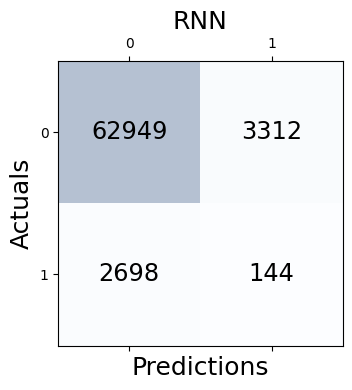

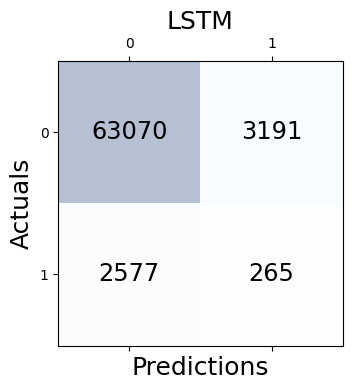

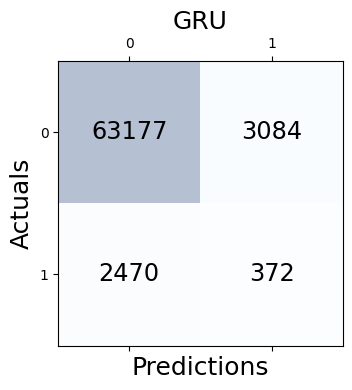

In [15]:
from publications.lacci2024.plotter import Plotter
plotter = Plotter()
for y_true, y_pred, y_pred_score in list_ys_true_pred:
    plotter.plot_matrix(y_true, y_pred,name_cycler, filename=f"confusion_{sequence_length}")


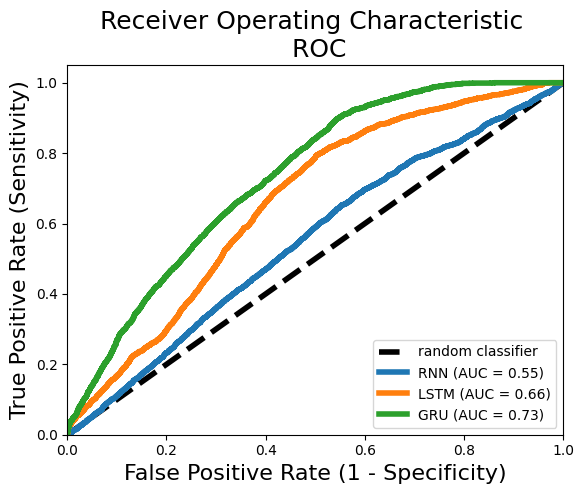

In [16]:
from sklearn import metrics
import cycler
title = "ROC"
fig, ax = plt.subplots()
ax.plot([0,1], [0,1], "k--",linewidth=4, label='random classifier')
for y_true, y_pred, y_pred_score in list_ys_true_pred:
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_score)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr,  linewidth=4, label=f"{next(name_cycler)} (AUC = {round(auc,2) })")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate (1 - Specificity)", fontsize=16)
ax.set_ylabel("True Positive Rate (Sensitivity)", fontsize=16)
ax.set_title(f"Receiver Operating Characteristic \n {title}", fontsize=18)
ax.legend(loc="lower right")
plt.savefig(f"roc_{sequence_length}.pdf")

plt.show()

In [17]:
def roc(y_true, y_pred_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_score)
    auc = metrics.auc(fpr, tpr)
    return auc

In [18]:
import scipy.stats as st

In [19]:
def roc_samples(y_t, y_s):
    N = len(y_t)
    rocs = []
    for b in range(30):
        choices = np.random.choice(N, size=N)
        ys_t = y_t[choices]
        ys_p = y_s[choices]
        fpr, tpr, thresholds = metrics.roc_curve(ys_t, ys_p)
        auc = metrics.auc(fpr, tpr)
        rocs.append(auc)
    return rocs

cis = []
for y_true, y_pred, y_pred_score in list_ys_true_pred:
    rocs = roc_samples(y_true, y_pred_score)
    roc_mean = np.mean(rocs)
    roc_std = np.std(rocs)
    roc_lb = roc_mean - 1.96 * roc_std
    roc_up = roc_mean + 1.96 * roc_std
    ci = f'{round(roc_mean, 2)} {round(roc_lb, 2), round(roc_up, 2)}'
    cis.append(ci)


In [20]:
cis

['0.55 (0.54, 0.56)', '0.66 (0.65, 0.67)', '0.73 (0.72, 0.74)']

In [21]:
import pandas as pd

In [22]:
df_ci = pd.DataFrame({
        "Model": names,
        "95% Confidence Interval": cis
    })
print(df_ci.to_latex(index=False, escape=True))

\begin{tabular}{ll}
\toprule
Model & 95\% Confidence Interval \\
\midrule
RNN & 0.55 (0.54, 0.56) \\
LSTM & 0.66 (0.65, 0.67) \\
GRU & 0.73 (0.72, 0.74) \\
\bottomrule
\end{tabular}

